In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.stats import chi2_contingency
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import joblib
import pickle
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
import numpy as np

In [58]:
sales_data = pd.read_csv("train_v9rqX0R.csv")
validation_data = pd.read_csv("test_AbJTz2l.csv")

In [59]:
#Feature Engineering

sales_data['Outlet_Age'] = 2025 - sales_data['Outlet_Establishment_Year']
sales_data['Item_Visibility'] = sales_data['Item_Visibility']*100
sales_data['Item_Fat_Content'] = sales_data['Item_Fat_Content'].replace({
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular'
})

In [60]:
categorical_cols = sales_data.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical Columns:", categorical_cols)

Categorical Columns: ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


In [ ]:

def impute_outlet_size(row):
    if pd.isna(row['Outlet_Size']) or row['Outlet_Size'] == 'Missing':
        year = row['Outlet_Establishment_Year']
        otype = row['Outlet_Type']
        loc = row['Outlet_Location_Type']
        
        if year == 1987:
            return 'High'
        elif otype == 'Supermarket Type3':
            return 'Medium'
        elif otype == 'Grocery Store':
            return 'Small'
        elif loc == 'Tier 2':
            return 'Small'
        elif year in [1997, 2004]:
            return 'Small'
        elif year in [1999, 2009]:
            return 'Medium'
        elif year == 1985:
            if otype == 'Supermarket Type1':
                return 'Medium'
            elif otype == 'Grocery Store':
                return 'Small'
    else:
        return row['Outlet_Size']
    
sales_data['Outlet_Size'] = sales_data.apply(impute_outlet_size, axis=1)

# Replace missing Item_Weight values with the mean weight of the corresponding Item_Identifier
sales_data['Item_Weight'] = sales_data.groupby('Item_Identifier')['Item_Weight'].transform(lambda x: x.fillna(x.mean()))
sales_data['Item_Weight'] = sales_data.groupby('Item_Type')['Item_Weight'].transform(lambda x: x.fillna(x.mean()))
sales_data = sales_data.drop(["Outlet_Establishment_Year"], axis = 1)


In [62]:
sales_data.Item_Weight.isna().sum()

0

In [63]:
sales_data.Outlet_Size.isna().sum()

0

In [64]:
train_data, test_data = train_test_split(sales_data, test_size=0.2, random_state=42, shuffle=True)

In [65]:
X_train = train_data.drop('Item_Outlet_Sales', axis=1)
y_train = train_data['Item_Outlet_Sales']
X_test = test_data.drop('Item_Outlet_Sales', axis=1)
y_test = test_data['Item_Outlet_Sales']

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Parameters: {'random_strength': 1, 'learning_rate': 0.01, 'l2_leaf_reg': 3, 'iterations': 1000, 'depth': 6, 'bagging_temperature': 1.0}
R2 Score: 0.6205
RMSE: 1015.6246
MAE: 710.7976


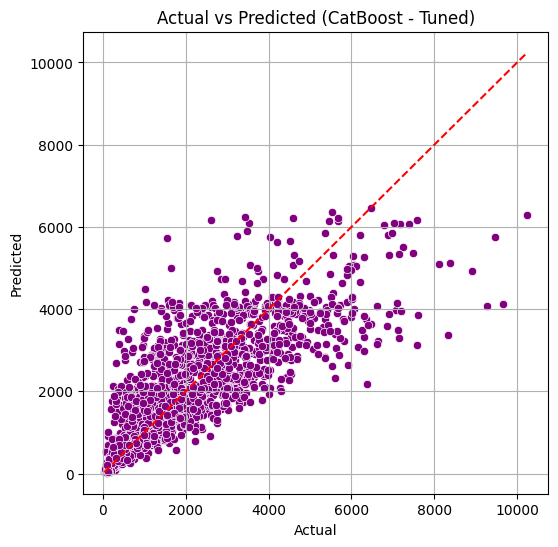

In [ ]:


train_pool = Pool(X_train, y_train, cat_features=categorical_cols)
test_pool = Pool(X_test, y_test, cat_features=categorical_cols)

# Define the model
model = CatBoostRegressor(
    loss_function='RMSE',
    nan_mode='Min',
    task_type='CPU', 
    cat_features=list(categorical_cols)
)

# Parameter grid
param_dist = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.03, 0.05],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0.2, 0.5, 1.0],
    'random_strength': [1, 2, 5]
}

# Randomized search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_

# Predict
y_pred = best_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nBest Parameters: {random_search.best_params_}")
print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (CatBoost - Tuned)')
plt.grid(True)
plt.show()


In [67]:
# TESTING ON VALIDATION DATA

In [ ]:
id_column = validation_data[['Item_Identifier', 'Outlet_Identifier']]
validation_data['Outlet_Age'] = 2025 - validation_data['Outlet_Establishment_Year']
validation_data['Item_Visibility'] = validation_data['Item_Visibility']*100
validation_data['Item_Fat_Content'] = validation_data['Item_Fat_Content'].replace({
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular'
})

validation_data['Outlet_Size'] = validation_data.apply(impute_outlet_size, axis=1)

validation_data['Item_Weight'] = validation_data.groupby('Item_Identifier')['Item_Weight'].transform(lambda x: x.fillna(x.mean()))
validation_data['Item_Weight'] = validation_data.groupby('Item_Type')['Item_Weight'].transform(lambda x: x.fillna(x.mean()))
validation_data = validation_data.drop(["Outlet_Establishment_Year"], axis = 1)


In [69]:
validation_data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Age
0,FDW58,20.750,Low Fat,0.756484,Snack Foods,107.8622,OUT049,Medium,Tier 1,Supermarket Type1,26
1,FDW14,8.300,Regular,3.842768,Dairy,87.3198,OUT017,Small,Tier 2,Supermarket Type1,18
2,NCN55,14.600,Low Fat,9.957491,Others,241.7538,OUT010,Small,Tier 3,Grocery Store,27
3,FDQ58,7.315,Low Fat,1.538839,Snack Foods,155.0340,OUT017,Small,Tier 2,Supermarket Type1,18
4,FDY38,13.600,Regular,11.859931,Dairy,234.2300,OUT027,Medium,Tier 3,Supermarket Type3,40
...,...,...,...,...,...,...,...,...,...,...,...
5676,FDB58,10.500,Regular,1.349647,Snack Foods,141.3154,OUT046,Small,Tier 1,Supermarket Type1,28
5677,FDD47,7.600,Regular,14.299090,Starchy Foods,169.1448,OUT018,Medium,Tier 3,Supermarket Type2,16
5678,NCO17,10.000,Low Fat,7.352856,Health and Hygiene,118.7440,OUT045,Small,Tier 2,Supermarket Type1,23
5679,FDJ26,15.300,Regular,0.000000,Canned,214.6218,OUT017,Small,Tier 2,Supermarket Type1,18


In [70]:
y_pred = best_model.predict(validation_data)

In [ ]:
id_column_reset = id_column.reset_index(drop=True)

predictions = pd.DataFrame({
    'Item_Identifier': id_column_reset['Item_Identifier'],
    'Outlet_Identifier': id_column_reset['Outlet_Identifier'],
    'Predicted_Sales': y_pred
})

print(predictions.head())
predictions.columns = ["Item_Identifier","Outlet_Identifier", "Item_Outlet_Sales" ]
predictions.to_csv("prediction_4.csv")

  Item_Identifier Outlet_Identifier  Predicted_Sales
0           FDW58            OUT049      1678.287546
1           FDW14            OUT017      1386.709466
2           NCN55            OUT010       625.934449
3           FDQ58            OUT017      2551.415588
4           FDY38            OUT027      6115.356688
